In [1]:
!pip install -q tensorflow pillow transformers sentencepiece

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
from PIL import Image
import io
import requests
import pandas as pd
from transformers import pipeline
from google.colab import files
import IPython.display as display_img

In [3]:
uploaded = files.upload()
for fn in uploaded.keys():
    image_path = fn
    print(f"Uploaded file: {fn}")

Saving sneaker.jpg to sneaker.jpg
Uploaded file: sneaker.jpg


In [4]:
img = keras_image.load_img(image_path, target_size=(224, 224))
x = keras_image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔮 Top Predictions:
1. running_shoe (35.28%)
2. sandal (15.81%)
3. clog (9.74%)


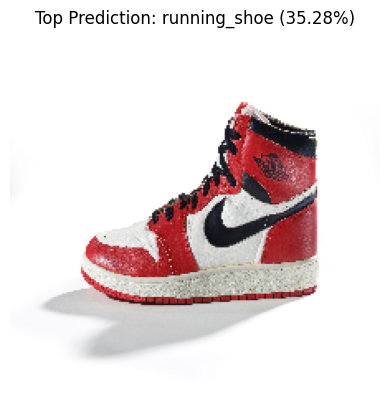

In [5]:
model = MobileNetV2(weights='imagenet')
preds = model.predict(x)
decoded = decode_predictions(preds, top=3)[0]

print("\n🔮 Top Predictions:")
for i, (imagenetID, label, prob) in enumerate(decoded):
    print(f"{i+1}. {label} ({prob*100:.2f}%)")

# Display uploaded image
plt.imshow(img)
plt.axis('off')
plt.title(f"Top Prediction: {decoded[0][1]} ({decoded[0][2]*100:.2f}%)")
plt.show()

In [6]:
def search_products(query, max_results=5):
    print(f"\nSearching for products related to: '{query}'...")
    url = "https://fakestoreapi.com/products"
    response = requests.get(url)
    products = response.json()

    filtered = []
    for product in products:
        title = product['title'].lower()
        if query.lower() in title:
            filtered.append(product)
        if len(filtered) >= max_results:
            break

    if not filtered:
        filtered = products[:max_results]
    return filtered

In [7]:
predicted_label = decoded[0][1].replace('_', ' ')
products = search_products(predicted_label)


Searching for products related to: 'running shoe'...


In [8]:
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu


In [9]:
def summarize_product(title, description):
    text = f"Product: {title}. Details: {description}"
    summary = summarizer(text, max_length=60, min_length=20, do_sample=False)[0]['summary_text']
    return summary

for p in products:
    p['summary'] = summarize_product(p['title'], p['description'])


Your max_length is set to 60, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 60, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


In [10]:
df = pd.DataFrame(products)[['title', 'price', 'summary', 'image']]

print(f"\nFound {len(df)} products:\n")
for idx, row in df.iterrows():
    print(f"{idx+1}. {row['title']} — ${row['price']}")
    print(f"Summary: {row['summary']}\n")
    display_img.display(display_img.Image(url=row['image'], width=150))


Found 5 products:

1. Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops — $109.95
Summary:  Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops . Stash your laptop (up to 15 inches) in the padded sleeve .



2. Mens Casual Premium Slim Fit T-Shirts  — $22.3
Summary:  Mens Casual Premium Slim Fit T-Shirts . Slim-fitting style, contrast raglan long sleeve, three-button henley placket, light weight & soft fabric for breathable and comfortable wearing .



3. Mens Cotton Jacket — $55.99
Summary:  Good gift choice for you or your family member in this thanksgiving or Christmas Day . Product: Mens Cotton Jacket . Great outerwear jackets for Spring/Autumn/Winter .



4. Mens Casual Slim Fit — $15.99
Summary:  The color could be slightly different between on the screen and in practice . Please note that body builds vary by person, therefore, detailed size information should be reviewed below on the product description .



5. John Hardy Women's Legends Naga Gold & Silver Dragon Station Chain Bracelet — $695.0
Summary:  John Hardy Women's Legends Naga Gold & Silver Dragon Station Chain Bracelet . Inspired by mythical water dragon that protects ocean's pearl . Wear facing inward to be bestowed with love and abundance .

